# Importing the Liabraries

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
import math
import random
from sklearn.metrics import confusion_matrix
from tqdm import tqdm_notebook

# Importing the Dataset

In [6]:
dataset = pd.read_csv("train.csv")
features = ["Brand", "Capacity", "Network Support", "Operating System", "Screen Size", "Internal Memory", "RAM", "VoLTE"]     # 8 features selected
X_train = dataset[features]
y_train = dataset[["Rating"]]
X_test = pd.read_csv("test.csv")[features]
total_dataset = pd.concat([X_train, X_test], ignore_index=True)

# Cleaning the Dataset

In [7]:
#############################
# Filling out the missing values
#############################
# Remove columns containing nan in Brand
X_train.isnull().sum()
X_test.isnull().sum()
total_dataset = total_dataset.drop(5)

# Filling missing values in Operating System
total_dataset.isnull().sum()
total_dataset["Operating System"] = total_dataset["Operating System"].fillna("Android v8.1 (Oreo)")

# Filling missing values in VoLTE
total_dataset["VoLTE"] = total_dataset["VoLTE"].fillna("no")

#############################
# Encoding the categorical data
#############################
# Encoding the brands
labelcoder = LabelEncoder()
total_dataset["Brand"] = labelcoder.fit_transform(total_dataset["Brand"])

# Encoding the Network Support
labelcoder2 = LabelEncoder()
total_dataset[["Network Support"]] = labelcoder2.fit_transform(total_dataset[["Network Support"]])

# Encoding the Operating System
labelcode3 = LabelEncoder()
total_dataset[["Operating System"]] = labelcode3.fit_transform(total_dataset[["Operating System"]])

# Getting the capacity values
total_dataset["Capacity"] = total_dataset["Capacity"].str.rstrip(" mAh")
total_dataset["Capacity"] = total_dataset["Capacity"].astype(int)

# Getting the Screen Size value
for index, row in total_dataset.iterrows():
    total_dataset.at[index, "Screen Size"] = row["Screen Size"].split(" ")[0]
total_dataset["Screen Size"] = total_dataset["Screen Size"].astype(float)

# Encoding VoLTE
labelcoder4 = LabelEncoder()
total_dataset[["VoLTE"]] = labelcoder4.fit_transform(total_dataset[["VoLTE"]])

# Getting the Internal Memory
total_dataset["Internal Memory"] = total_dataset["Internal Memory"].fillna("Random")
for index, row in total_dataset.iterrows():
    if (row['Internal Memory'].split(" ")[0] == "Random"):
        total_dataset.at[index, 'Internal Memory'] = 0
    else:
        total_dataset.at[index, 'Internal Memory'] = row['Internal Memory'].split(" ")[0]
total_dataset['Internal Memory'] = total_dataset['Internal Memory'].astype(float)
total_dataset['Internal Memory'] = total_dataset['Internal Memory'].replace(0, 32)

# Getting the RAM
total_dataset["RAM"] = total_dataset["RAM"].fillna("Random")
for index, row in total_dataset.iterrows():
    if (row['RAM'].split(" ")[0] == "Random"):
        total_dataset.at[index, 'RAM'] = float(0)
    else:
        if(row['RAM'].split(" ")[1] == "MB"):
            total_dataset.at[index, 'RAM'] = float(row['RAM'].split(" ")[0])/1024
        else:
            total_dataset.at[index, 'RAM'] = float(row['RAM'].split(" ")[0])
total_dataset["RAM"] = total_dataset["RAM"].astype(float)
total_dataset['RAM'] = total_dataset['RAM'].replace(0, 4)

#############################
# Encoding the results
#############################
# Deleting row 5
y_train = y_train.drop(5)

# Encoding the rating
for index, row in y_train.iterrows():
    if(row["Rating"] >= 4):
        y_train.at[index, "Rating"] = 1
    else:
        y_train.at[index, "Rating"] = 0
        
#############################
# Splitting data back into train and test set
#############################
X_train = total_dataset.iloc[:354, :]
X_test = total_dataset.iloc[354:, :]

C:\Users\Atul Singh\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Scaling of the Dataset

In [8]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Splitting into the Train Test and Validation sets

In [9]:
x_train, x_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.25, random_state =1, stratify = y_train)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size = 0.5, random_state = 1, stratify = y_test)
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()

In [10]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape, X_test.shape)

(265, 8) (265, 1) (45, 8) (45, 1) (44, 8) (44, 1) (119, 8)


# Neural Network Class

In [15]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size):
        self.nx = input_size
        self.nh = len(hidden_size)
        self.no = 1
        self.size = [self.nx] + hidden_size + [self.no]
        self.w = {}
        self.b = {}
        for i in range(self.nh + 1):
            self.w[i+1] = np.random.randn(self.size[i], self.size[i+1])
            self.b[i+1] = np.zeros((1, self.size[i+1]))
    def Sigmoid(self, x):
        return 1/(1 + np.exp(-x))
    def model(self, x):
        self.h = {}
        self.a = {}
        self.a[0] = x.reshape(1, -1)
        for i in range(self.nh + 1):
            self.h[i+1] = np.matmul(self.a[i], self.w[i+1]) + self.b[i+1]
            self.a[i+1] = self.Sigmoid(self.h[i+1])
        return self.a[self.nh + 1]
    def grad_Sigmoid(self, x):
        return x*(1 - x)
    def grad(self, x, y):
        self.model(x)
        self.dh = {}
        self.da = {}
        self.db = {}
        self.dw = {}
        self.dh[self.nh + 1] = (self.a[self.nh + 1] - y)
        for i in range(self.nh + 1, 0, -1):
            self.dw[i] = np.matmul(self.a[i-1].T, self.dh[i])
            self.db[i] = self.dh[i]
            self.da[i-1] = np.matmul(self.dh[i], self.w[i].T)
            self.dh[i-1] = np.multiply(self.da[i-1], self.grad_Sigmoid(self.a[i-1]))
    def predict(self, X):
        Y_pred = []
        for x in X:
            y_pred = self.model(x)
            Y_pred.append(y_pred)
        return np.array(Y_pred).squeeze()

    def fit(self, X, Y, epochs, lr):
        loss = []
        m = X.shape[1]
        for z in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
            for x,y in zip(X, Y):
                self.grad(x, y)
                for i in range(self.nh + 1):
                    self.w[i+1] -= lr * self.dw[i+1]/m
                    self.b[i+1] -= lr * self.db[i+1]/m
            y_pred = self.predict(X)
            loss.append(mean_squared_error(y_pred, Y))   
        plt.plot(loss, 'r-');
        return self.w[1]

# Weights and Bias Initialization along with object creation

In [41]:
ffnn = NeuralNetwork(8, [])

# Training the Dataset

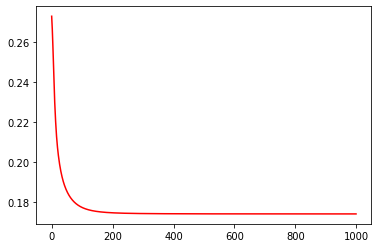

In [42]:
importance = ffnn.fit(x_train, y_train, 1000, 0.009)
importance = importance[:, 0]

# Feature Importance

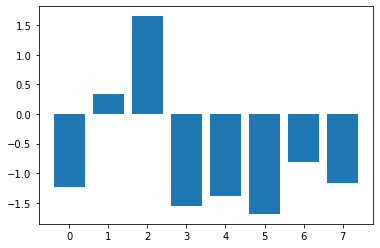

In [34]:
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [44]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(x_train, y_train)
print(accuracy_score(model.predict(x_train), y_train))
print(accuracy_score(model.predict(x_test), y_test))

C:\Users\Atul Singh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Atul Singh\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7320754716981132
0.6666666666666666


# Checking the accuracy of the model

In [45]:
y_pred_train = ffnn.predict(x_train)
y_pred_binarised_train = (y_pred_train >= 0.5).astype("int").ravel()
y_pred_test = ffnn.predict(x_test)
y_pred_binarised_test = (y_pred_test >= 0.5).astype("int").ravel()
accuracy_train = accuracy_score(y_pred_binarised_train, y_train)
accuracy_val = accuracy_score(y_pred_binarised_test, y_test)

print("Training accuracy", round(accuracy_train, 2))
print("Validation accuracy", round(accuracy_val, 2))

Training accuracy 0.73
Validation accuracy 0.67
